# LSTM model of StockData

[Intro to LSTM](https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/)

In this notebook we will go through a basic Long Short Term Memory (LSTM) model for time series. The notebooks does the following things:
* First load in the data. The preproccessing only consist of normalization and the creation of windows.
* Creation of the LSTM model
* Training the LSTM model
* Testing the LSTM model with 1 time step and with 1 window

## Importing libraries and loading in the data

### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import re
import math

In [2]:
import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal as smt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
import plotly
import os
from subprocess import check_output

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
# Use CPU to run the model
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### 1) Loading in the data

Select a stock or ETF for this HW from the ones available. 

In [4]:
filename = "ETFs\\adre.us.txt"#"<insert file name>"
print(filename)

df = pd.read_csv(filename, sep=",")
df['Label'] = filename
df['Date'] = pd.to_datetime(df['Date'])
df.head() 

ETFs\adre.us.txt


,Date,Open,High,Low,Close,Volume,OpenInt,Label
0,2005-02-25,19.065,19.416,19.065,19.416,72019,0,ETFs\adre.us.txt
1,2005-02-28,20.172,20.172,19.312,19.380,101346,0,ETFs\adre.us.txt
2,2005-03-01,19.798,19.798,19.209,19.268,53671,0,ETFs\adre.us.txt
3,2005-03-02,19.109,19.195,19.042,19.160,23894,0,ETFs\adre.us.txt
4,2005-03-03,19.744,19.744,19.127,19.187,28870,0,ETFs\adre.us.txt


### Visualize the data

Plotly is a nice visualization library that has some interactive plot options.

In [5]:
df

,Date,Open,High,Low,Close,Volume,OpenInt,Label
0,2005-02-25,19.065,19.4160,19.0650,19.4160,72019,0,ETFs\adre.us.txt
1,2005-02-28,20.172,20.1720,19.3120,19.3800,101346,0,ETFs\adre.us.txt
2,2005-03-01,19.798,19.7980,19.2090,19.2680,53671,0,ETFs\adre.us.txt
3,2005-03-02,19.109,19.1950,19.0420,19.1600,23894,0,ETFs\adre.us.txt
4,2005-03-03,19.744,19.7440,19.1270,19.1870,28870,0,ETFs\adre.us.txt
...,...,...,...,...,...,...,...,...
3196,2017-11-06,43.000,43.6084,43.0000,43.5700,11601,0,ETFs\adre.us.txt
3197,2017-11-07,43.680,43.6800,43.1700,43.2491,3400,0,ETFs\adre.us.txt
3198,2017-11-08,43.260,43.4928,43.2600,43.4357,2602,0,ETFs\adre.us.txt
3199,2017-11-09,43.120,43.1200,42.6810,43.0500,8449,0,ETFs\adre.us.txt


In [10]:
df

,Date,Open,High,Low,Close,Volume,OpenInt,Label
0,2005-02-25,19.065,19.4160,19.0650,19.4160,72019,0,ETFs\adre.us.txt
1,2005-02-28,20.172,20.1720,19.3120,19.3800,101346,0,ETFs\adre.us.txt
2,2005-03-01,19.798,19.7980,19.2090,19.2680,53671,0,ETFs\adre.us.txt
3,2005-03-02,19.109,19.1950,19.0420,19.1600,23894,0,ETFs\adre.us.txt
4,2005-03-03,19.744,19.7440,19.1270,19.1870,28870,0,ETFs\adre.us.txt
...,...,...,...,...,...,...,...,...
3196,2017-11-06,43.000,43.6084,43.0000,43.5700,11601,0,ETFs\adre.us.txt
3197,2017-11-07,43.680,43.6800,43.1700,43.2491,3400,0,ETFs\adre.us.txt
3198,2017-11-08,43.260,43.4928,43.2600,43.4357,2602,0,ETFs\adre.us.txt
3199,2017-11-09,43.120,43.1200,42.6810,43.0500,8449,0,ETFs\adre.us.txt


In [131]:
traces = []

df = df.sort_values('Date')
label = df['Label'].iloc[0]

trace = plotly.graph_objs.Scattergl(
    x=df['Date'],
    y=df['Close']#,mode='line',line=dict(color = "blue")
)


,Date,Open,High,Low,Close,Volume,OpenInt,Label
0,2005-02-25,19.065,19.4160,19.0650,19.4160,72019,0,ETFs\adre.us.txt
1,2005-02-28,20.172,20.1720,19.3120,19.3800,101346,0,ETFs\adre.us.txt
2,2005-03-01,19.798,19.7980,19.2090,19.2680,53671,0,ETFs\adre.us.txt
3,2005-03-02,19.109,19.1950,19.0420,19.1600,23894,0,ETFs\adre.us.txt
4,2005-03-03,19.744,19.7440,19.1270,19.1870,28870,0,ETFs\adre.us.txt
...,...,...,...,...,...,...,...,...
3196,2017-11-06,43.000,43.6084,43.0000,43.5700,11601,0,ETFs\adre.us.txt
3197,2017-11-07,43.680,43.6800,43.1700,43.2491,3400,0,ETFs\adre.us.txt
3198,2017-11-08,43.260,43.4928,43.2600,43.4357,2602,0,ETFs\adre.us.txt
3199,2017-11-09,43.120,43.1200,42.6810,43.0500,8449,0,ETFs\adre.us.txt


In [6]:
traces = []

df = df.sort_values('Date')
label = df['Label'].iloc[0]

trace = plotly.graph_objs.Scattergl(
    x=df['Date'],
    y=df['Close']#,mode='line',line=dict(color = "blue")
)
traces.append(trace)
    
layout = plotly.graph_objs.Layout(
    title='Plot '+label.split(sep='.')[0].upper(),
)
fig = plotly.graph_objs.Figure(data=traces, layout=layout)

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot(fig, filename='dataplot')

### 2) Creating windows and normalizing the data

The default window here is 10. The final question will ask you to consider this parameter in your final analysis and how it might impact your results.

In [126]:
training_set

,Open,High,Low,Close,Volume
0,19.065,19.4160,19.0650,19.4160,72019
1,20.172,20.1720,19.3120,19.3800,101346
2,19.798,19.7980,19.2090,19.2680,53671
3,19.109,19.1950,19.0420,19.1600,23894
4,19.744,19.7440,19.1270,19.1870,28870
...,...,...,...,...,...
3175,42.680,42.6902,42.5705,42.6500,5292
3176,42.800,42.8690,42.6060,42.6845,5674
3177,43.050,43.1700,42.9636,43.1300,14911
3178,43.190,43.3000,43.0700,43.2900,8522


In [143]:
window_len = 10

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(df["Date"][-(2*window_len+1):])[0]
print("split_date:",split_date)


# Split the training and test set
training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
test_set = test_set.drop(['Date','Label','OpenInt'], 1)

# Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_inputs[0].shape
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set[
    'Close'][:-window_len].values)-1
LSTM_training_outputs
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs[0].shape

split_date: 2017-10-13 00:00:00


(10, 5)

In [90]:
window_len = 10

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(df["Date"][-(2*window_len+1):])[0]
print("split_date:",split_date)


# Split the training and test set
training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
test_set = test_set.drop(['Date','Label','OpenInt'], 1)

# Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_inputs

LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set[
    'Close'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

# Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

split_date: 2017-10-13 00:00:00


In [146]:
(test_set['Close'][10:].values/test_set['Close'][:-10].values)-1

array([-0.01967553, -0.02587205, -0.00826989, -0.00882147, -0.00359947,
       -0.00393792,  0.01965832,  0.01072914,  0.0221728 ,  0.01631294,
        0.01065728])

In [153]:
LSTM_test_inputs

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 1.85097295e-02,  5.73300573e-03,  9.03041825e-03,
         -2.58215962e-03,  1.48346738e-01],
        [ 9.49216896e-03,  6.20100620e-03,  1.09315589e-02,
          7.22065728e-03,  6.41085791e-01],
        [ 2.44423351e-02,  1.60570961e-02,  2.30703422e-02,
          1.15023474e-02,  3.77457551e-01],
        [ 2.61034646e-02,  1.18170118e-02,  1.71102662e-02,
          9.15492958e-03, -2.07663092e-01]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-8.85368127e-03,  4.65332713e-04,  1.88412624e-03,
          9.82819487e-03,  4.29085603e-01],
        [ 5.82479031e-03,  1.02652396e-02,  1.39142723e-02,
          1.41209696e-02,  1.99513619e-01],
        [ 7.45573159e-03,  6.04932527e-03,  8.00753650e-03,
          1.17674747e-02, -3.10019455e-01],
        [ 5.82479031e-03,  4.42066077e-03,  5.98445596e-03,
  

In [152]:
LSTM_test_outputs

array([0.00938967, 0.02541775, 0.00795896, 0.00802274, 0.00139567,
       0.00125581])

In [92]:
print(LSTM_training_inputs.shape)
print(LSTM_training_outputs.shape)
print(LSTM_test_inputs.shape)
print(LSTM_test_outputs.shape)

(3170, 10, 5)
(3170,)
(11, 10, 5)
(11,)


## 3) LSTM model definition

LSTM's have a set of parameters that can be tuned to your data set. Consider these inputs: **activation function, loss function, dropout rate, optimizer, nn layers/architecture** and review your options in the documentation.

[Keras Docs](https://keras.io/api/layers/recurrent_layers/lstm/)

In [105]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

## 4) Training of the LSTM model

Just like most ML models choosing a stopping condition is important. Here we use **Epochs** or iterations to set this stopping condition where we also monitor the loss at each step. Consider **Epochs** as a parameter to adjust.

In [106]:
# Initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=5, batch_size=1, verbose=2, shuffle=True)

Epoch 1/5
3170/3170 - 5s - loss: 0.0231 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0158 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0144 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0141 - 5s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0137 - 4s/epoch - 1ms/step


### Plot of prediction of one data point ahead
As can be seen in the plot, one step prediction is not bad. The scale is a bit off, because the data is normalized. 

### Prediction of one window (n steps) ahead
As can be seen in the plot below, the performance degrades when predicting multiple time points ahead. However, compered to something like linear regression the performance is better. 

In [125]:
curr_frame = LSTM_test_inputs[0]
predicted = []
print(nn_model.predict(LSTM_test_inputs[0][np.newaxis,:,:])[0,0])
predicted.append(nn_model.predict(LSTM_test_inputs[0][np.newaxis,:,:])[0,0])
curr_frame = curr_frame[1:]
curr_frame = np.insert(curr_frame, [10-1], predicted[-1], axis=0)

-0.03461477


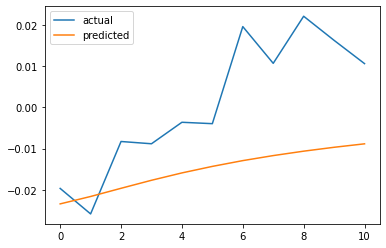

The Mean Absolute Error is: 0.016746579302144234


In [9]:
def predict_sequence_full(model, data, window_size):
    # Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(nn_model, LSTM_test_inputs, 10)

plt.plot(LSTM_test_outputs, label="actual")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, predictions)
print('The Mean Absolute Error is: {}'.format(MAE))

## Conclusion

For this HW your task is to select a stock or ETF from the provided folder. You will run the code above with the default parameters and understand the logic and flow of the program. Once you are confident the code runs you are to test different parameter settings. You are to report the best set of parameters that you find and explain the importance of each parameter and how it impacts the training of the model. To best know how much to adjust and how to interpret the impacts I suggest changing one parameter at a at a time. This is a manual grid search you are performing so that you can become familiar with each parameter. In the future you can have grid search algorithms find the best set for you. 

For each define the parameter and it's impact to the model. Report the set of values tested and the best parameter setting you found for each.

1) Window Length
2) LSTM Parameter: activation function
3) LSTM Parameter: loss function
4) LSTM Parameter: dropout rate
5) LSTM Parameter: optimizer
6) LSTM Parameter: nn layers/architecture
7) Epochs


The last cell has the questions 1-7 which expects a two part response, 2.pts each question, 1pt for the explanation of the parameter and 1 point for set of values tested with the best value for that particular parameters, this can be reported as an optimal set of parameters at the end. The 8th quest is submitted separately and asks you to perform back propagation on a simple NN for the final 1 pt. In all there are 15 points possible. Please download this notebook, import it into your workspace, download the stock or EFT in the files. You need to select one to train the NN on. Your completed HW should be a notebook with the optimal set of parameters and your answers in the last cell as markdown syntax. Then download the back propagation document and submit that answer as a separate document.

# Here are my answers to the above questions

In [10]:
filename = "ETFs\\adre.us.txt"
df = pd.read_csv(filename, sep=",")
df['Label'] = filename
df['Date'] = pd.to_datetime(df['Date'])
df.head() 

,Date,Open,High,Low,Close,Volume,OpenInt,Label
0,2005-02-25,19.065,19.416,19.065,19.416,72019,0,ETFs\adre.us.txt
1,2005-02-28,20.172,20.172,19.312,19.380,101346,0,ETFs\adre.us.txt
2,2005-03-01,19.798,19.798,19.209,19.268,53671,0,ETFs\adre.us.txt
3,2005-03-02,19.109,19.195,19.042,19.160,23894,0,ETFs\adre.us.txt
4,2005-03-03,19.744,19.744,19.127,19.187,28870,0,ETFs\adre.us.txt


In [11]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

## Window Length

split_date: 2017-10-27 00:00:00
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 1.85097295e-02  5.73300573e-03  9.03041825e-03 -2.58215962e-03
    1.48346738e-01]
  [ 9.49216896e-03  6.20100620e-03  1.09315589e-02  7.22065728e-03
    6.41085791e-01]
  [ 2.44423351e-02  1.60570961e-02  2.30703422e-02  1.15023474e-02
    3.77457551e-01]
  [ 2.61034646e-02  1.18170118e-02  1.71102662e-02  9.15492958e-03
   -2.07663092e-01]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [-8.85368127e-03  4.65332713e-04  1.88412624e-03  9.82819487e-03
    4.29085603e-01]
  [ 5.82479031e-03  1.02652396e-02  1.39142723e-02  1.41209696e-02
    1.99513619e-01]
  [ 7.45573159e-03  6.04932527e-03  8.00753650e-03  1.17674747e-02
   -3.10019455e-01]
  [ 5.82479031e-03  4.42066077e-03  5.98445596e-03  1.20028242e-02
    2.09143969e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 1.4

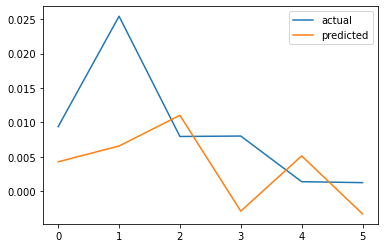

split_date: 2017-10-25 00:00:00
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [-1.06604434e-02 -1.04628150e-02  3.03094883e-03 -3.16518997e-03
   -3.77229719e-01]
  [-1.65694282e-02 -6.16047944e-03 -3.57557245e-03  2.50626566e-03
    3.88552815e-01]
  [ 1.63360560e-03 -4.62791774e-04  5.42255689e-03 -8.23655383e-05
    5.94540096e-01]
  [-7.23453909e-03  2.32558680e-06  7.31689991e-03  9.74501983e-03
    1.27873430e+00]
  [ 7.46791132e-03  9.79769720e-03  1.94122801e-02  1.40374410e-02
    9.12672561e-01]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [-5.97265599e-03  4.34782609e-03 -6.58655776e-03  5.68946387e-03
    1.22963885e+00]
  [ 1.24265212e-02  1.01057579e-02  2.38438112e-03  3.09261314e-03
    1.56039851e+00]
  [ 3.46281951e-03  1.05757932e-02  4.27299983e-03  1.29512028e-02
    2.65902864e+00]
  [ 1.83236934e-02  2.04747356e-02  1.63318303e-02  1.72572535e-02
    2.07123288e+00]
  [ 1.997

KeyboardInterrupt: 

In [155]:
window_lst = list(range(5,15))

window_dic = {}

for window_len in window_lst:
    split_date = list(df["Date"][-(2*window_len+1):])[0]
    print("split_date:",split_date)

    #Split the training and test set
    training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
    training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
    test_set = test_set.drop(['Date','Label','OpenInt'], 1)

    #Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set[
        'Close'][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)
    
    # initialise model architecture
    nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    print(LSTM_test_inputs)
    print(LSTM_test_outputs)
    
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=5, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    window_dic[window_len] = MAE
window_result = pd.DataFrame(window_dic.values(), window_dic.keys()).rename(columns={0: "MAE"})

        MAE
1  0.004486


<AxesSubplot:>

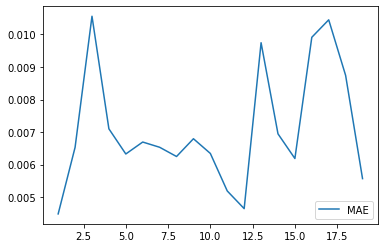

In [13]:
print(window_result.loc[window_result["MAE"] == window_result["MAE"].min()])
window_result.plot()

The model parameter window denotes the number of days we use to trace back the prices, which hence represents the histrorical performance of the underlying asset.

It can be shown that using window = 1 would be the best choice with lowest mean absolute error, the result may due to the fact that, the price variation would not be so large between two consecutive trading days. We can observe from the plot that, the MAE firstly gets higher, then drops down and pulls up again. 

## LSTM Parameter: activation function

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0365 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0364 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0364 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0364 - 5s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0364 - 4s/epoch - 1ms/step


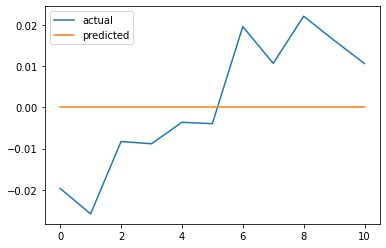

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0418 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0285 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0269 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0260 - 5s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0257 - 4s/epoch - 1ms/step


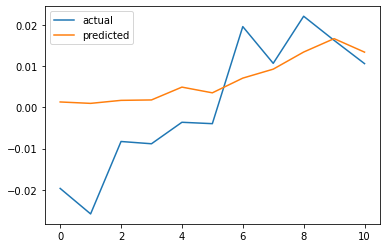

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.9962 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.9962 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.9962 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.9962 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.9962 - 4s/epoch - 1ms/step


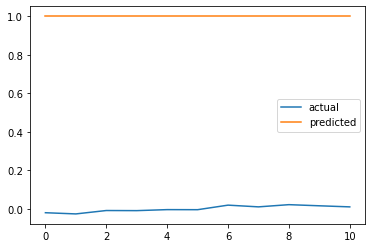

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0444 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0295 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0273 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0266 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0259 - 4s/epoch - 1ms/step


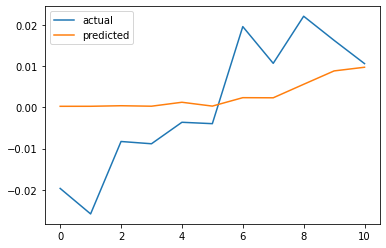

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0227 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0159 - 5s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0144 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0140 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0137 - 4s/epoch - 1ms/step


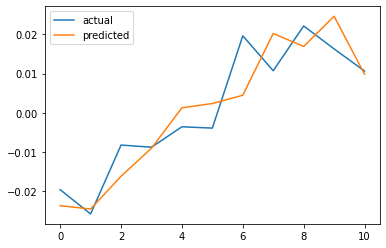

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0232 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0158 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0145 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0141 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0138 - 4s/epoch - 1ms/step


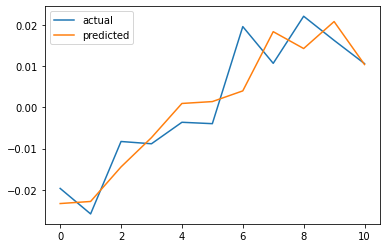

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0262 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0173 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0156 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0147 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0143 - 4s/epoch - 1ms/step


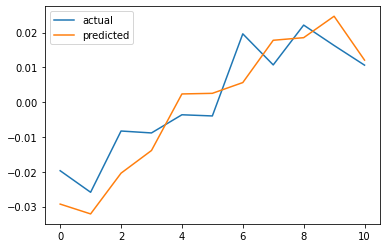

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0230 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0157 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0146 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0138 - 4s/epoch - 1ms/step


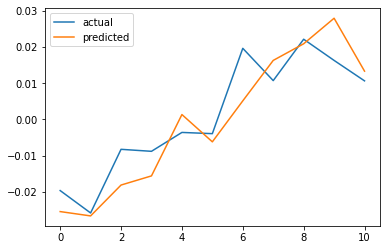

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0497 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0299 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0275 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0268 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0264 - 4s/epoch - 1ms/step


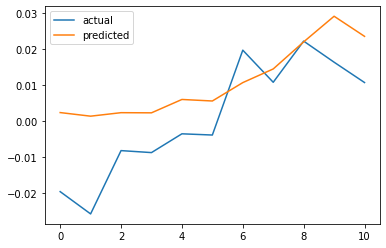

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0244 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0161 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0146 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step


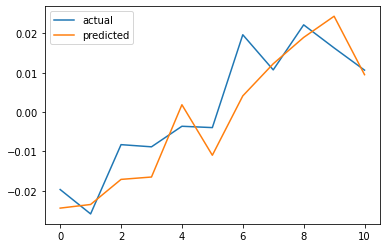

In [14]:
activation_lst = ["relu", "sigmoid", "softmax", "softplus", "softsign", 
                  "tanh", "selu", "elu", "exponential", "linear"]
activation_dic = {}

window_len = 10
for activation in activation_lst:
    def this_build_model(inputs, output_size, neurons, activ_func=activation, 
                         dropout=0.10, loss="mae", optimizer="adam"):
        model = Sequential()

        model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
        model.add(Dropout(dropout))
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))

        model.compile(loss=loss, optimizer=optimizer)
        return model

    split_date = list(df["Date"][-(2*window_len+1):])[0]
    print("split_date:",split_date)

    #Split the training and test set
    training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
    training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
    test_set = test_set.drop(['Date','Label','OpenInt'], 1)

    #Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set[
        'Close'][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)

    # initialise model architecture
    nn_model = this_build_model(LSTM_training_inputs, output_size=1, neurons = 32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=5, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    activation_dic[activation] = MAE
activation_result = pd.DataFrame(activation_dic.values(), activation_dic.keys()).rename(columns={0: "MAE"})

In [165]:
LSTM_test_outputs

array([ 0.01168414,  0.01513256,  0.02276995,  0.01786538,  0.01230784,
       -0.00092829,  0.00148872])

In [166]:
nn_model.predict(LSTM_test_inputs)

array([[-0.0073029 ],
       [-0.00512173],
       [ 0.00429591],
       [ 0.00646156],
       [ 0.00868135],
       [ 0.0020566 ],
       [-0.00216179]], dtype=float32)

           MAE
tanh  0.005479


<AxesSubplot:>

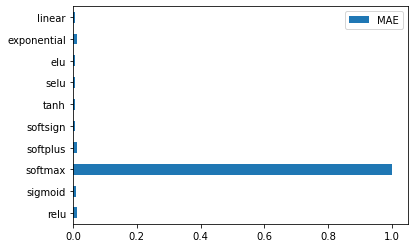

In [15]:
print(activation_result.loc[activation_result["MAE"] == activation_result["MAE"].min()])
activation_result.plot(kind="barh")

The LSTM parameter activation function is the function we use in every hidden layer node in the model. That is, for each node in our model, the value would be give by $\sigma(w\cdot x + b)$, where $\sigma$ is the activation function. If we use no activation function, the defualt set would be linear. However, a specified activation function type except linear function would introduce non-lineartiy into the model.

We can observe that the ``tanh`` activation function has the lowest error, however, it doesn't vary a lot from other activation functions except for ``softmax``, which has significantly higher error than other activation functions. This is becuase ``softmax`` function is a probabilistic function, and the vector returned by it would sum up to 1.

## LSTM Parameter: loss function

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0013 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 5.4588e-04 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 4.5618e-04 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 4.3707e-04 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 4.2026e-04 - 4s/epoch - 1ms/step


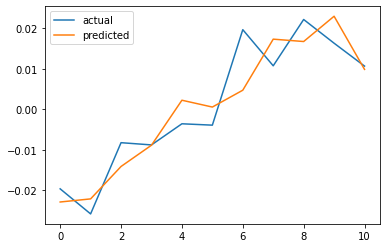

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0229 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0160 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0143 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0140 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0138 - 4s/epoch - 1ms/step


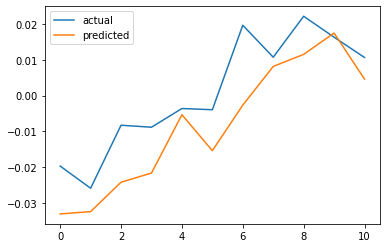

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 153750.9375 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 167885.2656 - 5s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 135851.4844 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 163576.8906 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 143367.5156 - 4s/epoch - 1ms/step


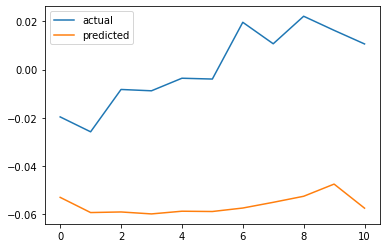

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 7.2380e-04 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 3.3209e-04 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 5s - loss: 2.2228e-04 - 5s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 1.8553e-04 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 1.6499e-04 - 4s/epoch - 1ms/step


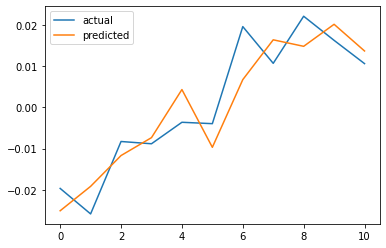

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0011 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 3.6827e-04 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 2.6161e-04 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 2.1965e-04 - 5s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 5s - loss: 2.0357e-04 - 5s/epoch - 1ms/step


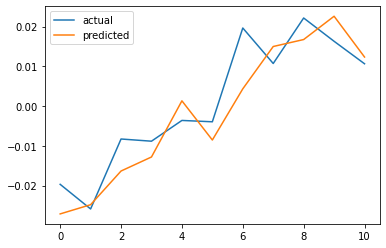

In [16]:
loss_lst = ["mse", "mae", "mape", "msle", "huber"]
loss_dic = {}

window_len = 10
for loss in loss_lst:
    def this_build_model(inputs, output_size, neurons, activ_func="linear", 
                         dropout=0.10, loss=loss, optimizer="adam"):
        model = Sequential()

        model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
        model.add(Dropout(dropout))
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))

        model.compile(loss=loss, optimizer=optimizer)
        return model

    split_date = list(df["Date"][-(2*window_len+1):])[0]
    print("split_date:",split_date)

    #Split the training and test set
    training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
    training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
    test_set = test_set.drop(['Date','Label','OpenInt'], 1)

    #Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set[
        'Close'][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)

    # initialise model architecture
    nn_model = this_build_model(LSTM_training_inputs, output_size=1, neurons = 32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=5, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    Error = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    loss_dic[loss] = Error
loss_result = pd.DataFrame(loss_dic.values(), loss_dic.keys()).rename(columns={0: "Error"})

        Error
mse  0.005243


<AxesSubplot:>

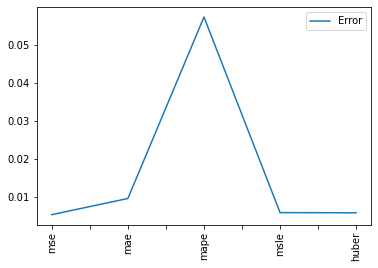

In [17]:
print(loss_result.loc[loss_result["Error"] == loss_result["Error"].min()])
loss_result.plot(rot=90)

The loss function is the function that the model would seek to minimize during training. Here, the ``mse`` (Mean Squared Error) function would give us the lowest error value, however, this is becuase we used different measurement.

## LSTM Parameter: dropout rate

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0200 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0157 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 5s - loss: 0.0146 - 5s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0141 - 5s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0137 - 4s/epoch - 1ms/step


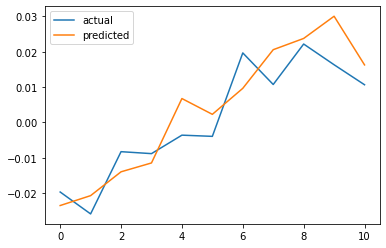

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0216 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0159 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0144 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0137 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0135 - 4s/epoch - 1ms/step


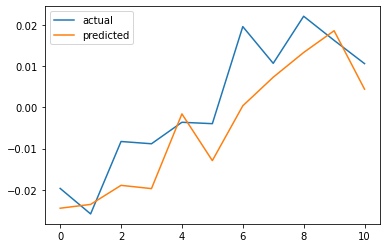

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0269 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0166 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0149 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0141 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 5s - loss: 0.0138 - 5s/epoch - 1ms/step


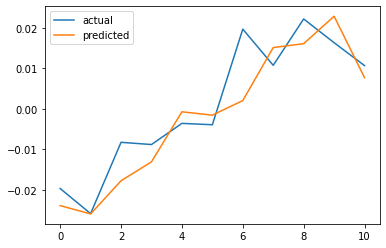

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0254 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0165 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0149 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0142 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0140 - 4s/epoch - 1ms/step


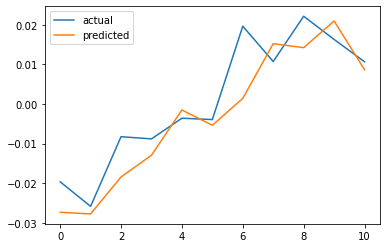

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0285 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0165 - 5s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 5s - loss: 0.0150 - 5s/epoch - 2ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0144 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0142 - 4s/epoch - 1ms/step


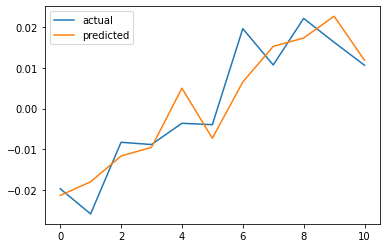

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0262 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0166 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0152 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0147 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0144 - 4s/epoch - 1ms/step


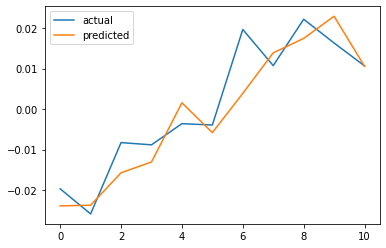

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0255 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0167 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0155 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0149 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0146 - 4s/epoch - 1ms/step


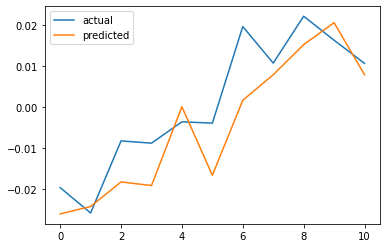

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0257 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0168 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 5s - loss: 0.0157 - 5s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0151 - 5s/epoch - 2ms/step
Epoch 5/5
3170/3170 - 5s - loss: 0.0148 - 5s/epoch - 2ms/step


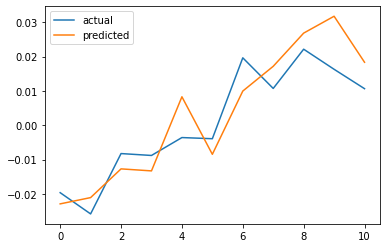

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0318 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0174 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0163 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0155 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0151 - 4s/epoch - 1ms/step


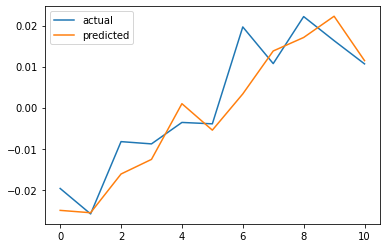

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0306 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0176 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0165 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0155 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0155 - 4s/epoch - 1ms/step


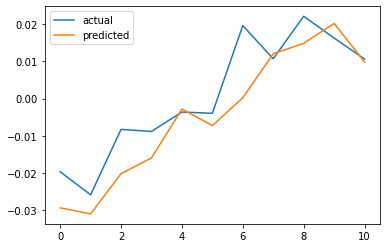

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0307 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0182 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0169 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0163 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0158 - 4s/epoch - 1ms/step


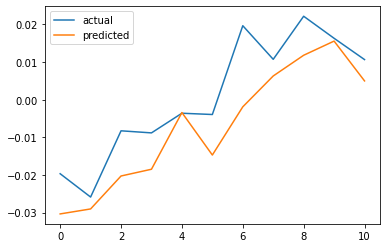

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0312 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0185 - 5s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 5s - loss: 0.0173 - 5s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0166 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0161 - 4s/epoch - 1ms/step


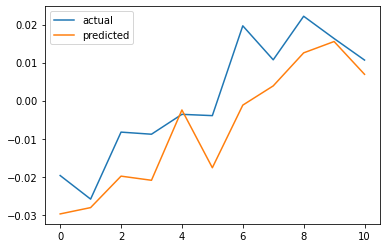

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0407 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0196 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0182 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0171 - 5s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0164 - 4s/epoch - 1ms/step


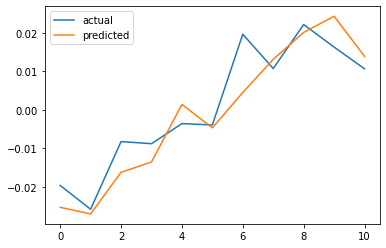

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0338 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0201 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0182 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0174 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 5s - loss: 0.0172 - 5s/epoch - 1ms/step


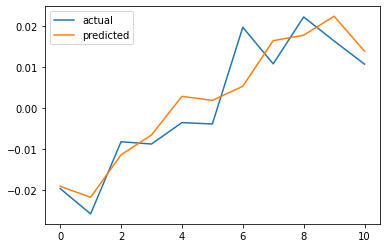

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0383 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0208 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0188 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0180 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0178 - 4s/epoch - 1ms/step


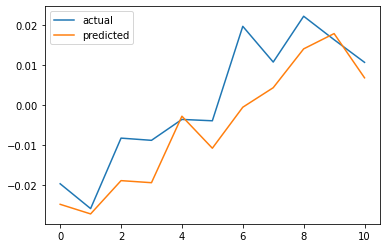

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0433 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0218 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0201 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0192 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0184 - 4s/epoch - 1ms/step


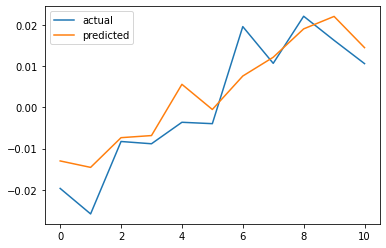

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0512 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0232 - 5s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0212 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0202 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0199 - 4s/epoch - 1ms/step


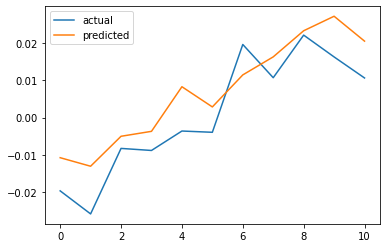

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0456 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0246 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0225 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0212 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0212 - 4s/epoch - 1ms/step


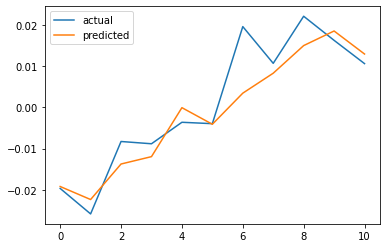

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0508 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0255 - 5s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0241 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0236 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0230 - 4s/epoch - 1ms/step


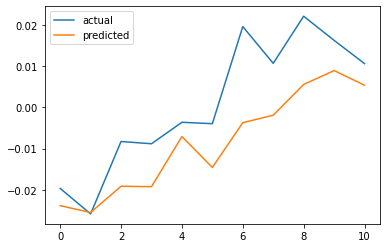

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0789 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0304 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0281 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0279 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0271 - 4s/epoch - 1ms/step


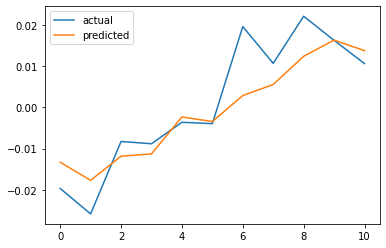

In [18]:
dropout_lst = np.arange(0, 1, 0.05)
dropout_dic = {}

for dropout in dropout_lst:
    def this_build_model(inputs, output_size, neurons, activ_func="linear", 
                         dropout=dropout, loss="mae", optimizer="adam"):
        model = Sequential()

        model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
        model.add(Dropout(dropout))
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))

        model.compile(loss="mae", optimizer=optimizer)
        return model

    split_date = list(df["Date"][-(2*window_len+1):])[0]
    print("split_date:",split_date)

    #Split the training and test set
    training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
    training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
    test_set = test_set.drop(['Date','Label','OpenInt'], 1)

    #Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set[
        'Close'][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)

    # initialise model architecture
    nn_model = this_build_model(LSTM_training_inputs, output_size=1, neurons = 32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=5, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    dropout_dic[dropout] = MAE
dropout_result = pd.DataFrame(dropout_dic.values(), dropout_dic.keys()).rename(columns={0: "MAE"})

           MAE
0.85  0.004235


<AxesSubplot:>

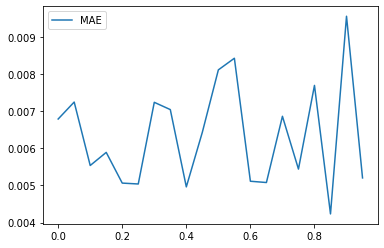

In [19]:
print(dropout_result.loc[dropout_result["MAE"] == dropout_result["MAE"].min()])
dropout_result.plot()

Dropout regularization is the fraction that we randomly "dropping out" unit activations in a single network for each single gradient step, the higher the dropout is, the stronger the regularization the it performs.

From the output, we can observe that with the increase of the dropout, the error firstly reduced and then increased, and the approximate minimum was reached when $\text{dropout} \approx 0.85$.

## LSTM Parameter: optimizer

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0371 - 5s/epoch - 1ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0255 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0234 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0224 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0214 - 4s/epoch - 1ms/step


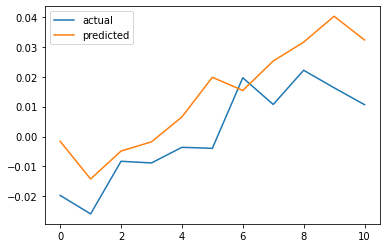

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0233 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0155 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0143 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0140 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step


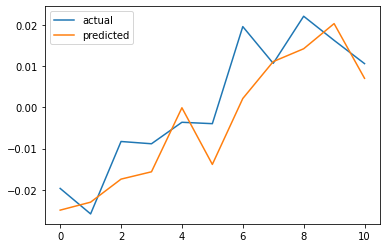

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0229 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0161 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0147 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step


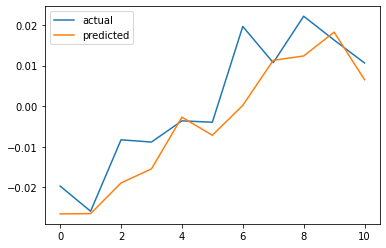

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 6s - loss: 0.1043 - 6s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0845 - 5s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0722 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0642 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0599 - 4s/epoch - 1ms/step


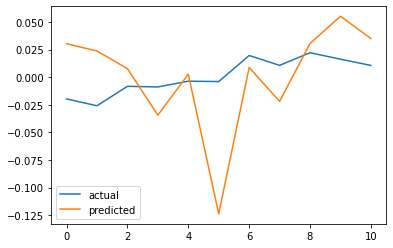

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0420 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0356 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0338 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0322 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0319 - 4s/epoch - 1ms/step


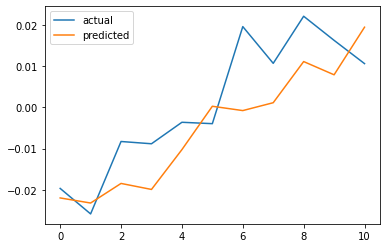

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0302 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0210 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0183 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0174 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0161 - 4s/epoch - 1ms/step


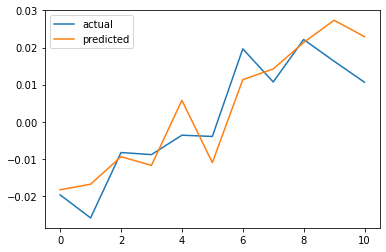

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0227 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0157 - 5s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0144 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0140 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0137 - 4s/epoch - 1ms/step


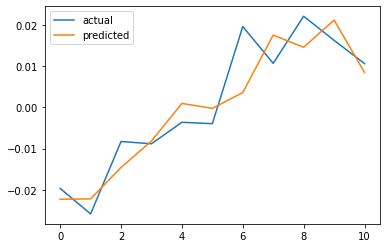

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 5s - loss: 0.0359 - 5s/epoch - 1ms/step


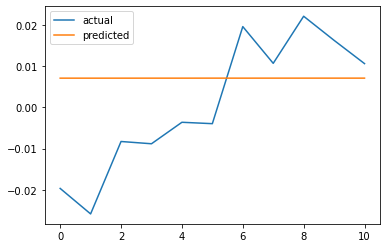

In [20]:
optimizer_lst = ["sgd", "rmsprop", "adam", "adadelta", "adagrad", "adamax", "nadam", "ftrl"]
optimizer_dic = {}

for optimizer in optimizer_lst:
    def this_build_model(inputs, output_size, neurons, activ_func="linear", 
                         dropout=0.10, loss="mae", optimizer=optimizer):
        model = Sequential()

        model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
        model.add(Dropout(dropout))
        model. add(Dense(units=output_size))
        model.add(Activation(activ_func))

        model.compile(loss="mae", optimizer=optimizer)
        return model

    split_date = list(df["Date"][-(2*window_len+1):])[0]
    print("split_date:",split_date)

    #Split the training and test set
    training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
    training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
    test_set = test_set.drop(['Date','Label','OpenInt'], 1)

    #Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set[
        'Close'][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)

    # initialise model architecture
    nn_model = this_build_model(LSTM_training_inputs, output_size=1, neurons = 32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=5, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    optimizer_dic[optimizer] = MAE
optimizer_result = pd.DataFrame(optimizer_dic.values(), optimizer_dic.keys()).rename(columns={0: "MAE"})

            MAE
nadam  0.005371


<AxesSubplot:>

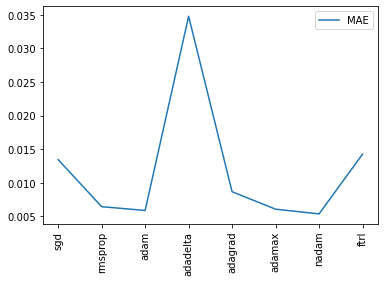

In [21]:
print(optimizer_result.loc[optimizer_result["MAE"] == optimizer_result["MAE"].min()])
optimizer_result.plot(rot=90)

An optimizer is one of the two arguments required for compiling our model. Here, we would choose ``nadam`` as our optimizer since it generates lowest error.

## LSTM Parameter: nn layers/architecture

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0246 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0163 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0146 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0141 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0140 - 4s/epoch - 1ms/step


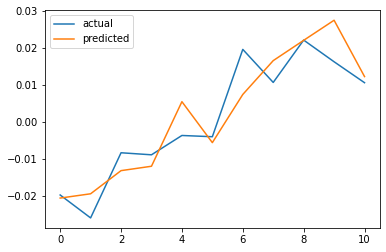

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0233 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0154 - 5s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0144 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0136 - 4s/epoch - 1ms/step


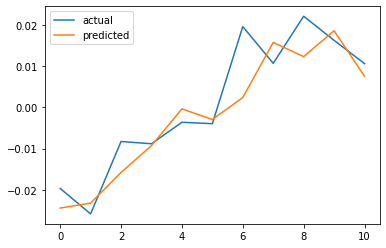

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0248 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0157 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0145 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0140 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0138 - 4s/epoch - 1ms/step


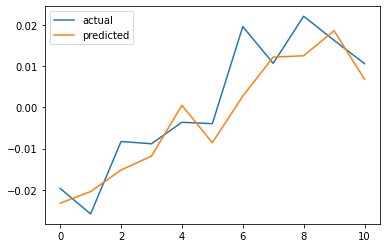

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0236 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0157 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0145 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0141 - 5s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0138 - 4s/epoch - 1ms/step


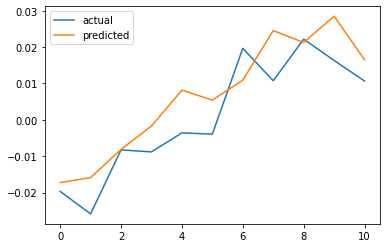

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0225 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0156 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0145 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step


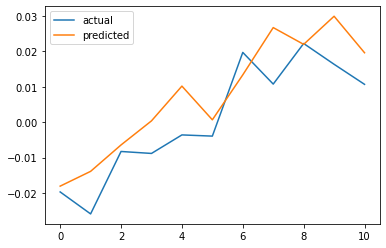

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0231 - 5s/epoch - 1ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0158 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0143 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0138 - 4s/epoch - 1ms/step


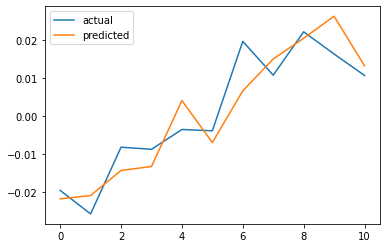

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0229 - 5s/epoch - 1ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0156 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0145 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0142 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0140 - 4s/epoch - 1ms/step


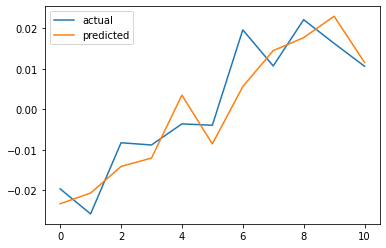

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0210 - 5s/epoch - 1ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0155 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0145 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0138 - 4s/epoch - 1ms/step


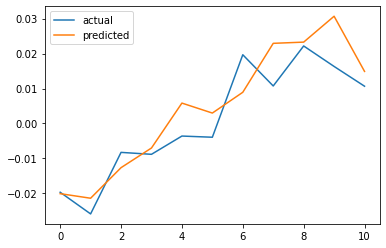

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 6s - loss: 0.0216 - 6s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0156 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0144 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0141 - 5s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0137 - 4s/epoch - 1ms/step


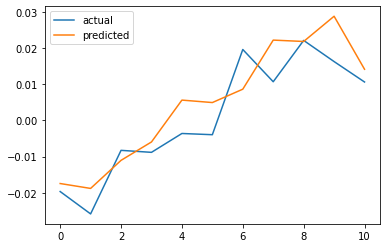

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0218 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0154 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0143 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0143 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0138 - 4s/epoch - 1ms/step


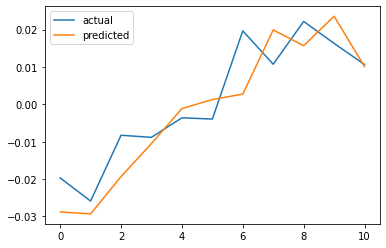

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0226 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0155 - 5s/epoch - 2ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0145 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0141 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0140 - 4s/epoch - 1ms/step


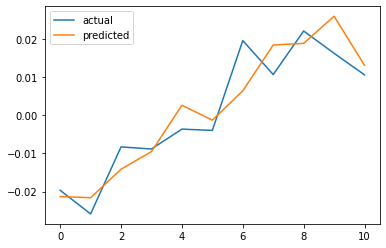

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0207 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0153 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0146 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0141 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step


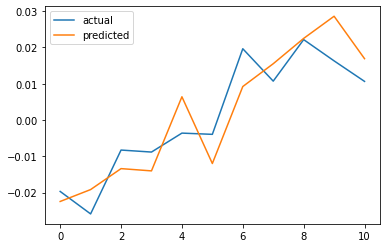

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0212 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0153 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0146 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0142 - 5s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0139 - 4s/epoch - 1ms/step


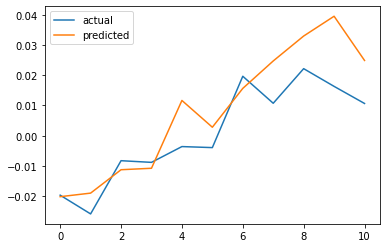

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 6s - loss: 0.0214 - 6s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0153 - 5s/epoch - 2ms/step
Epoch 3/5
3170/3170 - 6s - loss: 0.0146 - 6s/epoch - 2ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0141 - 5s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0141 - 4s/epoch - 1ms/step


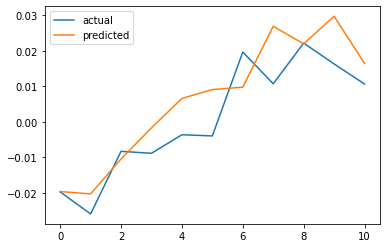

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0209 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0156 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 5s - loss: 0.0145 - 5s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0142 - 5s/epoch - 2ms/step
Epoch 5/5
3170/3170 - 5s - loss: 0.0139 - 5s/epoch - 1ms/step


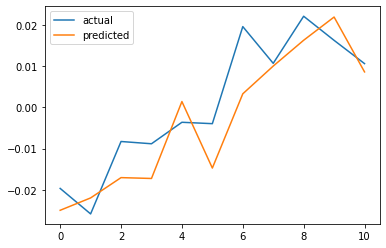

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 6s - loss: 0.0206 - 6s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0152 - 5s/epoch - 2ms/step
Epoch 3/5
3170/3170 - 5s - loss: 0.0144 - 5s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 5s - loss: 0.0142 - 5s/epoch - 2ms/step
Epoch 5/5
3170/3170 - 5s - loss: 0.0140 - 5s/epoch - 2ms/step


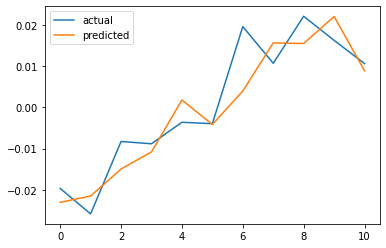

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 6s - loss: 0.0207 - 6s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 5s - loss: 0.0152 - 5s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 5s - loss: 0.0147 - 5s/epoch - 2ms/step
Epoch 4/5
3170/3170 - 6s - loss: 0.0141 - 6s/epoch - 2ms/step
Epoch 5/5
3170/3170 - 5s - loss: 0.0141 - 5s/epoch - 2ms/step


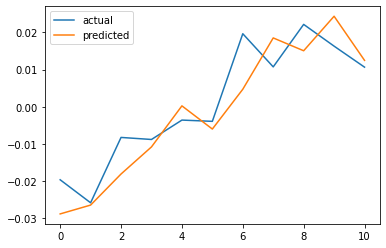

In [22]:
neuron_lst = np.arange(32, 168, 8)
neuron_dic = {}

for neurons in neurons_lst:
    split_date = list(df["Date"][-(2*window_len+1):])[0]
    print("split_date:",split_date)

    #Split the training and test set
    training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
    training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
    test_set = test_set.drop(['Date','Label','OpenInt'], 1)

    #Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set[
        'Close'][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)

    # initialise model architecture
    nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = neurons)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=5, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    neuron_dic[neurons] = MAE
neuron_result = pd.DataFrame(neuron_dic.values(), neuron_dic.keys()).rename(columns={0: "MAE"})

          MAE
152  0.005162


<AxesSubplot:>

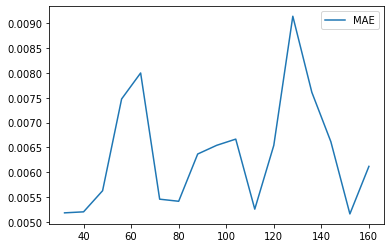

In [23]:
print(neurons_result.loc[neurons_result["MAE"] == neurons_result["MAE"].min()])
neurons_result.plot()

The	NN architecture	is made of neurons, which are simulations of human brain, which is a process that generates some inputs, then converts and transfers them to the node (activation function) and then returns an output NN architecture also contains the bias, transfer function and activation function.

Here, I tested different NN architectures with number of neurons from 32 to 168, and concluded that we would get the lowest error when the number is ``152``.

## Epochs

split_date: 2017-10-13 00:00:00
Epoch 1/5
3170/3170 - 5s - loss: 0.0361 - 5s/epoch - 2ms/step
Epoch 2/5
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/5
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 4/5
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 5/5
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step


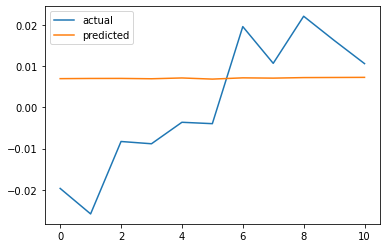

split_date: 2017-10-13 00:00:00
Epoch 1/6
3170/3170 - 5s - loss: 0.0361 - 5s/epoch - 2ms/step
Epoch 2/6
3170/3170 - 5s - loss: 0.0359 - 5s/epoch - 1ms/step
Epoch 3/6
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/6
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/6
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 6/6
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step


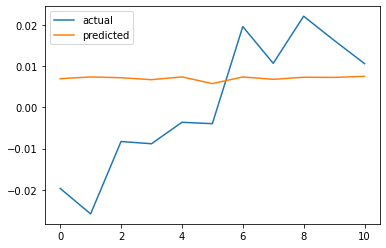

split_date: 2017-10-13 00:00:00
Epoch 1/7
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 2ms/step
Epoch 2/7
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/7
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/7
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 5/7
3170/3170 - 5s - loss: 0.0358 - 5s/epoch - 1ms/step
Epoch 6/7
3170/3170 - 4s - loss: 0.0357 - 4s/epoch - 1ms/step
Epoch 7/7
3170/3170 - 4s - loss: 0.0356 - 4s/epoch - 1ms/step


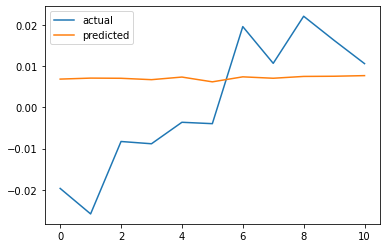

split_date: 2017-10-13 00:00:00
Epoch 1/8
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 2ms/step
Epoch 2/8
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/8
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/8
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/8
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 6/8
3170/3170 - 5s - loss: 0.0359 - 5s/epoch - 1ms/step
Epoch 7/8
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 8/8
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step


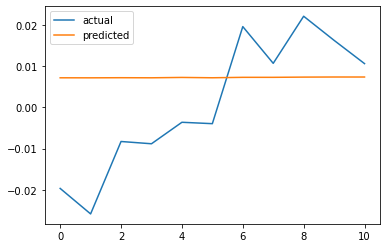

split_date: 2017-10-13 00:00:00
Epoch 1/9
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 1ms/step
Epoch 2/9
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/9
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/9
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/9
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 6/9
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 7/9
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 8/9
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 9/9
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step


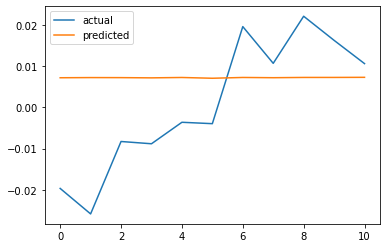

split_date: 2017-10-13 00:00:00
Epoch 1/10
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 2ms/step
Epoch 2/10
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/10
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/10
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/10
3170/3170 - 5s - loss: 0.0359 - 5s/epoch - 1ms/step
Epoch 6/10
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 7/10
3170/3170 - 5s - loss: 0.0359 - 5s/epoch - 1ms/step
Epoch 8/10
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 9/10
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 10/10
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step


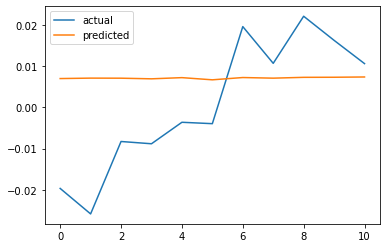

split_date: 2017-10-13 00:00:00
Epoch 1/11
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 2ms/step
Epoch 2/11
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/11
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/11
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/11
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 6/11
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 7/11
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 8/11
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 9/11
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 10/11
3170/3170 - 4s - loss: 0.0357 - 4s/epoch - 1ms/step
Epoch 11/11
3170/3170 - 4s - loss: 0.0356 - 4s/epoch - 1ms/step


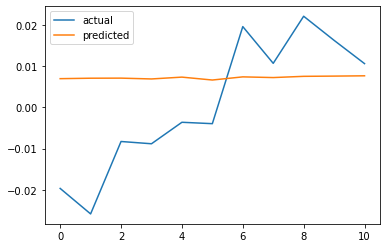

split_date: 2017-10-13 00:00:00
Epoch 1/12
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 2ms/step
Epoch 2/12
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/12
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/12
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/12
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 6/12
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 7/12
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 8/12
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 9/12
3170/3170 - 4s - loss: 0.0357 - 4s/epoch - 1ms/step
Epoch 10/12
3170/3170 - 4s - loss: 0.0356 - 4s/epoch - 1ms/step
Epoch 11/12
3170/3170 - 4s - loss: 0.0356 - 4s/epoch - 1ms/step
Epoch 12/12
3170/3170 - 4s - loss: 0.0354 - 4s/epoch - 1ms/step


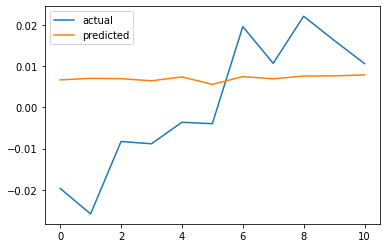

split_date: 2017-10-13 00:00:00
Epoch 1/13
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 2ms/step
Epoch 2/13
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/13
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 4/13
3170/3170 - 4s - loss: 0.0357 - 4s/epoch - 1ms/step
Epoch 5/13
3170/3170 - 4s - loss: 0.0357 - 4s/epoch - 1ms/step
Epoch 6/13
3170/3170 - 4s - loss: 0.0356 - 4s/epoch - 1ms/step
Epoch 7/13
3170/3170 - 4s - loss: 0.0355 - 4s/epoch - 1ms/step
Epoch 8/13
3170/3170 - 4s - loss: 0.0354 - 4s/epoch - 1ms/step
Epoch 9/13
3170/3170 - 4s - loss: 0.0353 - 4s/epoch - 1ms/step
Epoch 10/13
3170/3170 - 4s - loss: 0.0352 - 4s/epoch - 1ms/step
Epoch 11/13
3170/3170 - 4s - loss: 0.0350 - 4s/epoch - 1ms/step
Epoch 12/13
3170/3170 - 4s - loss: 0.0348 - 4s/epoch - 1ms/step
Epoch 13/13
3170/3170 - 4s - loss: 0.0345 - 4s/epoch - 1ms/step


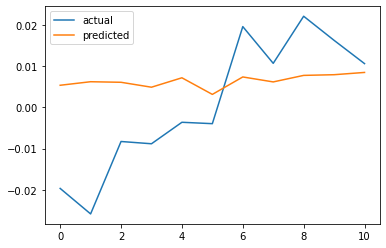

split_date: 2017-10-13 00:00:00
Epoch 1/14
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 1ms/step
Epoch 2/14
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/14
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/14
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/14
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 6/14
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 7/14
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 8/14
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 9/14
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 10/14
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 11/14
3170/3170 - 4s - loss: 0.0357 - 4s/epoch - 1ms/step
Epoch 12/14
3170/3170 - 5s - loss: 0.0357 - 5s/epoch - 1ms/step
Epoch 13/14
3170/3170 - 4s - loss: 0.0356 - 4s/epoch - 1ms/step
Epoch 14/14
3170/3170 - 4s - loss: 0.0355 - 4s/epoch - 1ms/step


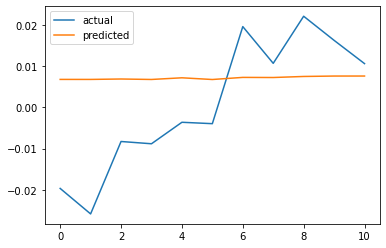

split_date: 2017-10-13 00:00:00
Epoch 1/15
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 2ms/step
Epoch 2/15
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/15
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/15
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/15
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 6/15
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 7/15
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 8/15
3170/3170 - 5s - loss: 0.0359 - 5s/epoch - 1ms/step
Epoch 9/15
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 10/15
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 11/15
3170/3170 - 4s - loss: 0.0357 - 4s/epoch - 1ms/step
Epoch 12/15
3170/3170 - 4s - loss: 0.0356 - 4s/epoch - 1ms/step
Epoch 13/15
3170/3170 - 4s - loss: 0.0354 - 4s/epoch - 1ms/step
Epoch 14/15
3170/3170 - 4s - loss: 0.0351 - 4s/epoch - 1ms/step
Epoch 15/15
3170/3170 - 4s - loss: 0.0347 - 4s/epoch - 1ms/step


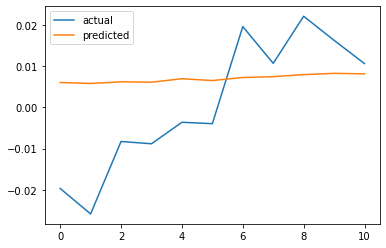

split_date: 2017-10-13 00:00:00
Epoch 1/16
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 1ms/step
Epoch 2/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 6/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 7/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 8/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 9/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 10/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 11/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 12/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 13/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 14/16
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 15/16
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 16/16
3170/

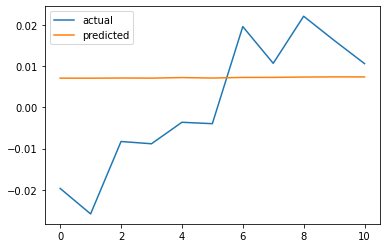

split_date: 2017-10-13 00:00:00
Epoch 1/17
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 2ms/step
Epoch 2/17
3170/3170 - 4s - loss: 0.0357 - 4s/epoch - 1ms/step
Epoch 3/17
3170/3170 - 4s - loss: 0.0356 - 4s/epoch - 1ms/step
Epoch 4/17
3170/3170 - 4s - loss: 0.0355 - 4s/epoch - 1ms/step
Epoch 5/17
3170/3170 - 4s - loss: 0.0353 - 4s/epoch - 1ms/step
Epoch 6/17
3170/3170 - 4s - loss: 0.0351 - 4s/epoch - 1ms/step
Epoch 7/17
3170/3170 - 4s - loss: 0.0349 - 4s/epoch - 1ms/step
Epoch 8/17
3170/3170 - 4s - loss: 0.0347 - 4s/epoch - 1ms/step
Epoch 9/17
3170/3170 - 4s - loss: 0.0343 - 4s/epoch - 1ms/step
Epoch 10/17
3170/3170 - 4s - loss: 0.0341 - 4s/epoch - 1ms/step
Epoch 11/17
3170/3170 - 4s - loss: 0.0336 - 4s/epoch - 1ms/step
Epoch 12/17
3170/3170 - 4s - loss: 0.0331 - 4s/epoch - 1ms/step
Epoch 13/17
3170/3170 - 4s - loss: 0.0325 - 4s/epoch - 1ms/step
Epoch 14/17
3170/3170 - 4s - loss: 0.0317 - 4s/epoch - 1ms/step
Epoch 15/17
3170/3170 - 4s - loss: 0.0309 - 4s/epoch - 1ms/step
Epoch 16/17
3170/

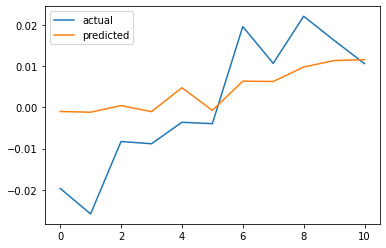

split_date: 2017-10-13 00:00:00
Epoch 1/18
3170/3170 - 5s - loss: 0.0359 - 5s/epoch - 2ms/step
Epoch 2/18
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 3/18
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 4/18
3170/3170 - 4s - loss: 0.0357 - 4s/epoch - 1ms/step
Epoch 5/18
3170/3170 - 4s - loss: 0.0356 - 4s/epoch - 1ms/step
Epoch 6/18
3170/3170 - 4s - loss: 0.0355 - 4s/epoch - 1ms/step
Epoch 7/18
3170/3170 - 4s - loss: 0.0354 - 4s/epoch - 1ms/step
Epoch 8/18
3170/3170 - 4s - loss: 0.0352 - 4s/epoch - 1ms/step
Epoch 9/18
3170/3170 - 4s - loss: 0.0351 - 4s/epoch - 1ms/step
Epoch 10/18
3170/3170 - 4s - loss: 0.0348 - 4s/epoch - 1ms/step
Epoch 11/18
3170/3170 - 4s - loss: 0.0346 - 4s/epoch - 1ms/step
Epoch 12/18
3170/3170 - 4s - loss: 0.0342 - 4s/epoch - 1ms/step
Epoch 13/18
3170/3170 - 4s - loss: 0.0338 - 4s/epoch - 1ms/step
Epoch 14/18
3170/3170 - 4s - loss: 0.0333 - 4s/epoch - 1ms/step
Epoch 15/18
3170/3170 - 4s - loss: 0.0327 - 4s/epoch - 1ms/step
Epoch 16/18
3170/

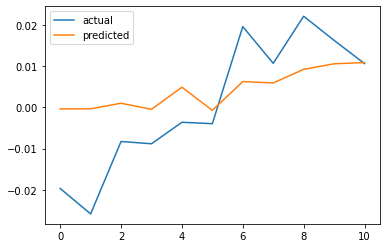

split_date: 2017-10-13 00:00:00
Epoch 1/19
3170/3170 - 5s - loss: 0.0360 - 5s/epoch - 2ms/step
Epoch 2/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 3/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 4/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 5/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 6/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 7/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 8/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 9/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 10/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 11/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 12/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 13/19
3170/3170 - 4s - loss: 0.0359 - 4s/epoch - 1ms/step
Epoch 14/19
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 15/19
3170/3170 - 4s - loss: 0.0358 - 4s/epoch - 1ms/step
Epoch 16/19
3170/

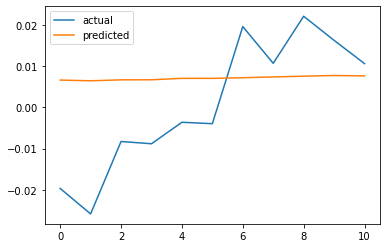

In [24]:
epochs_lst = range(5, 20)
epochs_dic = {}

for epochs in epochs_lst:
    def this_build_model(inputs, output_size, neurons, activ_func="linear", 
                         dropout=0.10, loss="mae", optimizer=optimizer):
        model = Sequential()

        model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
        model.add(Dropout(dropout))
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))

        model.compile(loss="mae", optimizer=optimizer)
        return model

    split_date = list(df["Date"][-(2*window_len+1):])[0]
    print("split_date:",split_date)

    #Split the training and test set
    training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
    training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
    test_set = test_set.drop(['Date','Label','OpenInt'], 1)

    #Create windows for training
    LSTM_training_inputs = []
    for i in range(len(training_set)-window_len):
        temp_set = training_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_training_inputs.append(temp_set)
    LSTM_training_inputs
    LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set[
        'Close'][:-window_len].values)-1

    LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
    LSTM_training_inputs = np.array(LSTM_training_inputs)

    # Create windows for testing
    LSTM_test_inputs = []
    for i in range(len(test_set)-window_len):
        temp_set = test_set[i:(i+window_len)].copy()

        for col in list(temp_set):
            temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

        LSTM_test_inputs.append(temp_set)
    LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set[
        'Close'][:-window_len].values)-1

    LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
    LSTM_test_inputs = np.array(LSTM_test_inputs)

    # initialise model architecture
    nn_model = this_build_model(LSTM_training_inputs, output_size=1, neurons = 32)
    # model output is next price normalised to 10th previous closing price train model on data
    # note: eth_history contains information on the training error per epoch
    nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                                epochs=epochs, batch_size=1, verbose=2, shuffle=True)
    plt.plot(LSTM_test_outputs, label = "actual")
    plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
    plt.legend()
    plt.show()
    MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
    epochs_dic[epochs] = MAE
epochs_result = pd.DataFrame(epochs_dic.values(), epochs_dic.keys()).rename(columns={0: "MAE"})

         MAE
17  0.009772


<AxesSubplot:>

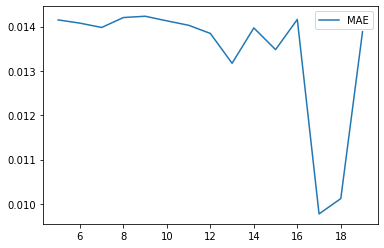

In [25]:
print(epochs_result.loc[epochs_result["MAE"] == epochs_result["MAE"].min()])
epochs_result.plot()

In our model, one epoch means that we completed one forward algorithm and one backpropagation. With the increase of the number of epochs, we get better outcomes (lower errors), and then the errors would get higher at some points due to overfitting. 

Here, I tested the number of epochs from 5 to 20, and concluded that when epochs = ``17``, we would get a the lowest error significantly, since it is really obvious as we can see in the plot above.

## Conclusion

The parameters I choose hence are:

window length = 1

activation function = tanh 

loss function = mse

dropout rate = 0.85 

optimizer = nadam

neurons = 152

epochs = 17

In [26]:
window_len = window_result.loc[window_result["MAE"] == window_result["MAE"].min()].index[0]
loss = loss_result.loc[loss_result["Error"] == loss_result["Error"].min()].index[0]
activ_func = activation_result.loc[activation_result["MAE"] == activation_result["MAE"].min()].index[0]
dropout = dropout_result.loc[dropout_result["MAE"] == dropout_result["MAE"].min()].index[0]
optimizer = optimizer_result.loc[optimizer_result["MAE"] == optimizer_result["MAE"].min()].index[0]
neurons = neurons_result.loc[neurons_result["MAE"] == neurons_result["MAE"].min()].index[0]
epochs = epochs_result.loc[epochs_result["MAE"] == epochs_result["MAE"].min()].index[0]

split_date: 2017-11-08 00:00:00
Epoch 1/17
3197/3197 - 4s - loss: 3.8853e-04 - 4s/epoch - 1ms/step
Epoch 2/17
3197/3197 - 3s - loss: 3.6437e-04 - 3s/epoch - 871us/step
Epoch 3/17
3197/3197 - 3s - loss: 3.5731e-04 - 3s/epoch - 869us/step
Epoch 4/17
3197/3197 - 3s - loss: 3.6031e-04 - 3s/epoch - 847us/step
Epoch 5/17
3197/3197 - 3s - loss: 3.5913e-04 - 3s/epoch - 818us/step
Epoch 6/17
3197/3197 - 3s - loss: 3.5808e-04 - 3s/epoch - 858us/step
Epoch 7/17
3197/3197 - 3s - loss: 3.5748e-04 - 3s/epoch - 887us/step
Epoch 8/17
3197/3197 - 3s - loss: 3.6086e-04 - 3s/epoch - 864us/step
Epoch 9/17
3197/3197 - 3s - loss: 3.5506e-04 - 3s/epoch - 872us/step
Epoch 10/17
3197/3197 - 3s - loss: 3.5845e-04 - 3s/epoch - 883us/step
Epoch 11/17
3197/3197 - 3s - loss: 3.5793e-04 - 3s/epoch - 852us/step
Epoch 12/17
3197/3197 - 3s - loss: 3.5977e-04 - 3s/epoch - 835us/step
Epoch 13/17
3197/3197 - 3s - loss: 3.5791e-04 - 3s/epoch - 835us/step
Epoch 14/17
3197/3197 - 3s - loss: 3.5756e-04 - 3s/epoch - 839us/step

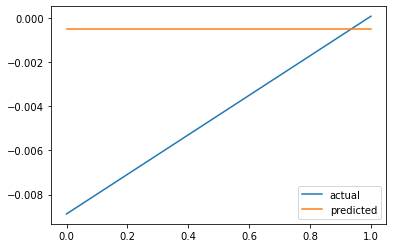

MAE:  0.004486353821837541


In [27]:
def test_build_model(inputs, output_size, neurons, activ_func=activ_func, 
                     dropout=dropout, loss=loss, optimizer=optimizer):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

split_date = list(df["Date"][-(2*window_len+1):])[0]
print("split_date:",split_date)

# Split the training and test set
training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
test_set = test_set.drop(['Date','Label','OpenInt'], 1)

# Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()

    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

LSTM_training_inputs
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set[
    'Close'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

# Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()

    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1

    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

# initialise model architecture
nn_model = test_build_model(LSTM_training_inputs, output_size=1, neurons = neurons)
# model output is next price normalised to 10th previous closing price train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=epochs, batch_size=1, verbose=2, shuffle=True)
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print("MAE: ", MAE)

# Part 2

In [4]:
def sigmoid(p):
    return 1 / (1 + math.exp(-p))

def backpropagation(x=1, y=4, z=5, target=np.array([0.1, 0.05]), lr=0.01):
    w1, w2, w3, w4, w5, w6, w7, w8, w9, w10 = 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.1
    h_1, h_2 = sigmoid(w1*x + w3*y + w5*z + 0.5), sigmoid(w2*x + w4*y + w6*z + 0.5)
    o_1, o_2 = sigmoid(w7*h_1 + w9*h_2 + 0.5), sigmoid(w8*h_1 + w10*h_2 + 0.5)
    sse = 1/2 * sum((target-np.array([o_1, o_2]))**2)
    sse_o1, sse_o2 = o_1 - target[0], o_2 - target[1]
    o1_n1, o2_n2 = o_1 * (1 - o_1), o_2 * (1 - o_2)
    n1_w7, n1_w9, n2_w8, n2_w10 = h_1, h_2, h_1, h_2
    sse_w7, sse_w8 = sse_o1 * o1_n1 * n1_w7, sse_o2 * o2_n2 * n2_w8
    sse_w9, sse_w10 = sse_o1 * o1_n1 * n1_w9, sse_o2 * o2_n2 * n2_w10
    new_w7, new_w8, new_w9, new_w10 = w7 + lr * n1_w7, w8 + lr * n2_w8, w9+ lr * n1_w9, w10 + lr * n2_w10
    h1_m1, h2_m2 = h_1 * (1 - h_1), h_2 * (1 - h_2)
    m1_w1, m1_w3, m1_w5, m2_w2, m2_w4, m2_w6 = w1, w3, w5, w2, w4, w6
    h1_w1, h1_w3, h1_w5 = h1_m1 * m1_w1, h1_m1 * m1_w3, h1_m1 * m1_w5
    h2_w2, h2_w4, h2_w6 = h2_m2 * m2_w2, h2_m2 * m2_w4, h2_m2 * m2_w6
    n1_h1, n1_h2, n2_h1, n2_h2 = w7, w9, w8, w10
    sse_h1, sse_h2 = o1_n1 * n1_h1 + o2_n2 * n2_h1, o1_n1 * n1_h2 + o2_n2 * n2_h2
    sse_m1, sse_m2 = sse_h1 * h1_m1, sse_h2 * h2_m2
    sse_w1, sse_w3, sse_w5 = sse_h1 * h1_w1, sse_h1 * h1_w3, sse_h1 * h1_w5
    sse_w2, sse_w4, sse_w6 = sse_h2 * h2_w2, sse_h2 * h2_w4, sse_h2 * h2_w6
    new_w1, new_w3, new_w5 = w1 + lr * sse_w1, w3 + lr * sse_w3, w5 + lr * sse_w5
    new_w2, new_w4, new_w6 = w2 + lr * sse_w2, w4 + lr * sse_w4, w6 + lr * sse_w6
    return {"new w1": new_w1, "new w2": new_w2, "new w3": new_w3, "new w4": new_w4, "new w5": new_w5, 
            "new w6": new_w6, "new w7": new_w7, "new w8": new_w8, "new w9": new_w9, "new w10": new_w10}

backpropagation()

{'new w1': 0.10000259641466082,
 'new w2': 0.2000010319300706,
 'new w3': 0.3000077892439824,
 'new w4': 0.4000020638601412,
 'new w5': 0.500012982073304,
 'new w6': 0.6000030957902117,
 'new w7': 0.7098661308217233,
 'new w8': 0.8098661308217234,
 'new w9': 0.9099503319834995,
 'new w10': 0.10995033198349943}